In [1]:
#!pip install graphviz
#!conda install -c anaconda graphviz

In [10]:
import graphviz
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from datetime import datetime
from sklearn.svm import LinearSVC
from sklearn.tree import export_graphviz
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

##only windows SO
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

SEED = 5
np.random.seed(SEED)

uri = "https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv"
dados = pd.read_csv(uri)
dados.head()

,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


### Formatando e limpando os dados

In [14]:
dados = dados.rename(columns={
    'mileage_per_year' : 'milhas_por_ano',
    'model_year' : 'ano_do_modelo',
    'price' : 'preco',
    'sold' : 'vendido'
})
dados.vendido = dados.vendido.map({
    'no' : 0,
    'yes' : 1
})
ano_atual = datetime.today().year
dados['idade_do_modelo'] = ano_atual - dados.ano_do_modelo
dados['km_por_ano'] = dados.milhas_por_ano * 1.60934
dados = dados.drop(columns = ["Unnamed: 0", "milhas_por_ano","ano_do_modelo"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,20,35085.22134
1,40557.96,1,22,12622.05362
2,89627.50,0,14,11440.79806
3,95276.14,0,5,43167.32682
4,117384.68,1,6,12770.11290


### Aplicando o estimador LinearSVC e tendo 68% de acurácia

In [29]:
x = dados[["preco", "idade_do_modelo","km_por_ano"]]
y = dados["vendido"]

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = LinearSVC(dual = False)
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 68.68%


### Aplicando uma 'dummy' classificação na estratégia stratified, para usar de comparação com o LinearSVC

In [55]:
dummy_stratified = DummyClassifier(strategy='stratified')
dummy_stratified.fit(treino_x, treino_y)
acuracia = dummy_stratified.score(teste_x, teste_y) * 100

print("A acurácia do dummy stratified foi %.2f%%" % acuracia)

A acurácia do dummy stratified foi 54.04%


### Aplicando uma 'dummy' classificação na estratégia most frequent, para usar de comparação com o LinearSVC

In [63]:
dummy_mostfrequent = DummyClassifier(strategy='most_frequent')
dummy_mostfrequent.fit(treino_x, treino_y)
acuracia = dummy_mostfrequent.score(teste_x, teste_y) * 100

print("A acurácia do dummy mostfrequent foi %.2f%%" % acuracia)

A acurácia do dummy mostfrequent foi 58.00%


### Deixando os dados na mesma escala para aplicar o estimador SVC

In [65]:
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 77.28%


### Aplicando uma árvore de decisão com até 3 níveis de profundidade

In [131]:
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = DecisionTreeClassifier(max_depth=3)
modelo.fit(raw_treino_x, treino_y)
previsoes = modelo.predict(raw_teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 79.36%


### Plotando a árvore de decisão

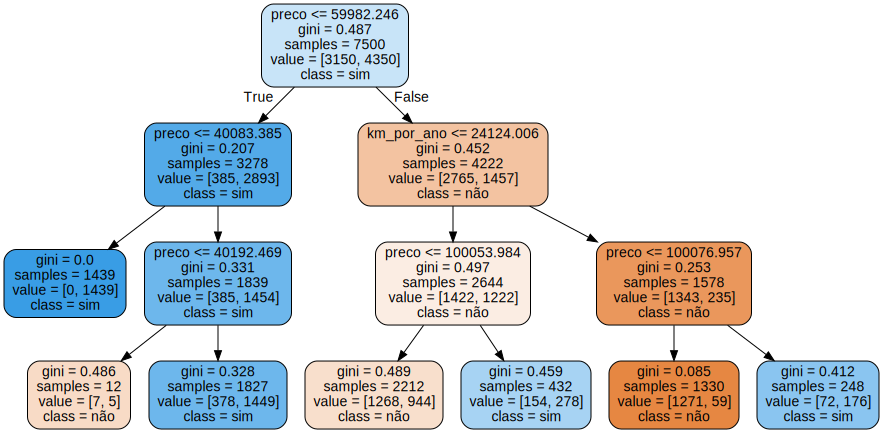

In [132]:
features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,
                          class_names = ["não", "sim"])
grafico = graphviz.Source(dot_data)
grafico